# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [328]:
import os, sys
root_folder_name = "bertaphore"
p = os.getcwd()
while os.path.basename(p) != root_folder_name:
    p = os.path.dirname(p)
sys.path.insert(0, p)

import torch
from conllu import parse
import pandas as pd
import numpy as np
import plotly.express as px
from modules import metric
from transformers import AutoTokenizer, AutoModel, utils
utils.logging.set_verbosity_error()  # Suppress standard warnings
from bertviz import model_view, head_view
from scipy.linalg import toeplitz
import seaborn as sns
import matplotlib.pyplot as plt
import scipy


model_name = "microsoft/xtremedistil-l12-h384-uncased"  # Find popular HuggingFace models here: https://huggingface.co/models
model = AutoModel.from_pretrained(model_name, output_attentions=True)  # Configure model to return attention values
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Experiment

In [3]:
burdenizer = metric.AttentionalBurden(model, tokenizer
                                      , prune_cls_sep=True
                                      , normalize_attention=True
                                      )
burdenizer.compute_burden("Alice is eating pizza. I like Bob.")

2.373994827270508

In [701]:
datasets_ud_english = ["GUM", "EWT", "LinES", "ParTUT", "Atis"]

data = open("/home/pierrick/datasets/Universal Dependencies 2.14/ud-treebanks-v2.14/UD_English-EWT/en_ewt-ud-train.conllu", "r").read()
data = open("/home/pierrick/datasets/Universal Dependencies 2.14/ud-treebanks-v2.14/UD_English-LinES/en_lines-ud-train.conllu", "r").read()
data = parse(data)
print(f'Number of texts: {len(data)}')
# data[4].metadata["text"]

Number of texts: 3176


In [702]:
D_RELATIONS = {"punct":False
               ,"root":False
               ,"nsubj":True
               ,"case":True
               ,"det":True
               ,"advmod":True
               ,"nmod":True
               ,"obl":True
               ,"obj":True
               ,"amod":True
               ,"compound":False
               ,"aux":True
               ,"conj":False
               ,"mark":False
               ,"cc":False
               ,"cop":True
               ,'advcl': False,
               'acl': True,
               'xcomp': True,
               'nummod': True,
               'ccomp': False,
               'flat': True,
               'parataxis': False,
               'appos': False,
               'discourse': False,
               'iobj': False,
               'expl': False,
               'fixed': False,
               'list': False,
               'csubj': False,
               'vocative': False,
               'goeswith': False,
               'reparandum': False,
               'orphan': False,
               'dislocated': False,
               'dep': False,
               '_': False
              }

In [703]:
l_head, l_deprel = [], []
for sentence_id, sentence in enumerate(data):
    for token_id, token in enumerate(sentence):
        l_head.append((sentence_id, token_id+1, token["id"], token["form"], token["deprel"], token["head"]))
        deps = token["deps"]
        if isinstance(deps, list):
            for dep in deps:
                l_deprel.append((sentence_id, token_id+1, token["id"], token["form"],)+dep)

In [704]:
df_deprel = pd.DataFrame(l_deprel, columns=["sentence_id", "token_id", "id", "form", "deprel", "head"])
df_deprel = pd.merge(df_deprel, df_deprel[["sentence_id", "token_id", "id"]].rename(columns={"token_id":"token_head"}).drop_duplicates(),
    how="left", left_on=["sentence_id", "head"], right_on=["sentence_id", "id"], suffixes=("", "_head")).drop(columns=["id_head"])
df_deprel["token_head"] = df_deprel.apply(lambda u: u["token_head"] if not(pd.isna(u["token_head"])) else u["head"], axis=1).astype(int)
df_deprel["length_relation"] = df_deprel["token_head"] - df_deprel["token_id"]
df_deprel["abs_length_relation"] = df_deprel["length_relation"].abs()
df_deprel["deprel_universal"] = df_deprel["deprel"].apply(lambda u: u.split(":")[0])
df_deprel.loc[df_deprel["sentence_id"] == 0]

,sentence_id,token_id,id,form,deprel,head,token_head,length_relation,abs_length_relation,deprel_universal


In [710]:
df_head = pd.DataFrame(l_head, columns=["sentence_id", "token_id", "id", "form", "deprel", "head"]).dropna(subset=["head"])
df_head["head"] = df_head["head"].astype(int)
df_head["id"] = df_head["id"].astype(int)
df_head = pd.merge(df_head, df_head[["sentence_id", "token_id", "id"]].rename(columns={"token_id":"token_head"}).drop_duplicates(),
    how="left", left_on=["sentence_id", "head"], right_on=["sentence_id", "id"], suffixes=("", "_head")).drop(columns=["id_head"])
df_head["token_head"] = df_head.apply(lambda u: u["token_head"] if not(pd.isna(u["token_head"])) else u["head"], axis=1).astype(int)
df_head["length_relation"] = df_head["head"] - df_head["id"]
df_head["abs_length_relation"] = df_head["length_relation"].abs()
df_head["deprel_universal"] = df_head["deprel"].apply(lambda u: u.split(":")[0])
df_head.loc[df_head["sentence_id"] == 0]

,sentence_id,token_id,id,form,deprel,head,token_head,length_relation,abs_length_relation,deprel_universal
0,0,1,1,Show,root,0,0,-1,1,root
1,0,2,2,All,obj,1,1,-1,1,obj


In [711]:
df_ud = df_deprel.copy() if len(df_deprel) > 0 else df_head.copy()
df_ud["deprel_order"] = df_ud["deprel_universal"].map({k: i for i, k in enumerate(list(D_RELATIONS.keys()))})
df_ud.head()

,sentence_id,token_id,id,form,deprel,head,token_head,length_relation,abs_length_relation,deprel_universal,deprel_order
0,0,1,1,Show,root,0,0,-1,1,root,1
1,0,2,2,All,obj,1,1,-1,1,obj,8
2,1,1,1,About,case,5,5,4,4,case,3
3,1,2,2,ANSI,compound,5,5,3,3,compound,10
4,1,3,3,SQL,flat,2,2,-1,1,flat,21


# EDA

Text(0.5, 1.0, 'Length of relations')

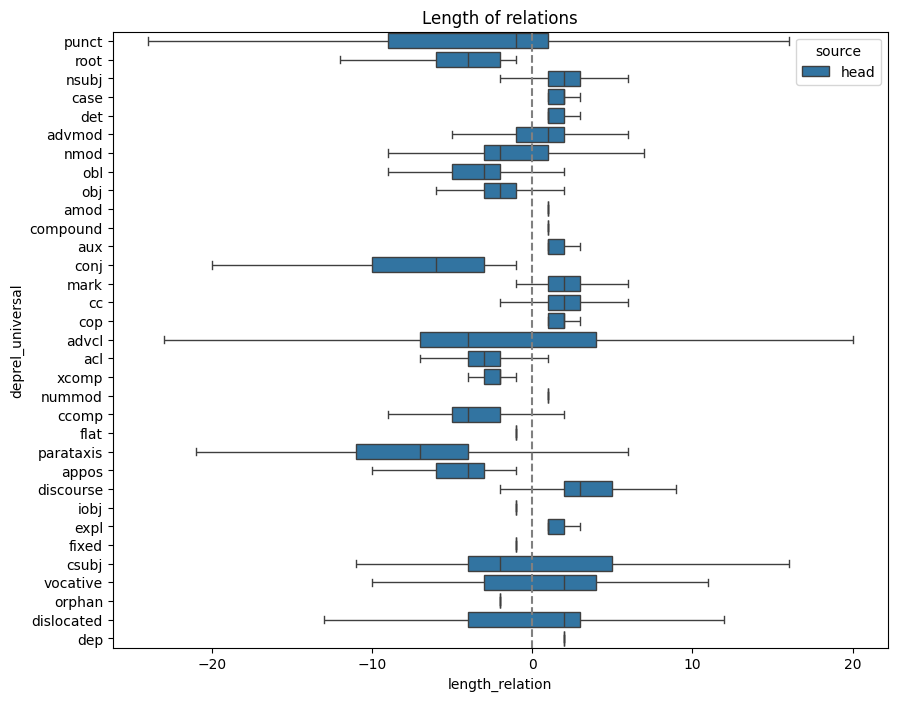

In [713]:
fig, ax = plt.subplots(figsize=(10, 8))
df_deprel["source"] = "deprel"
df_head["source"] = "head"
df = pd.concat([df_deprel, df_head])
df["deprel_order"] = df["deprel_universal"].map({k: i for i, k in enumerate(list(D_RELATIONS.keys()))})
ax = sns.boxplot(data=df.sort_values(by="deprel_order"), y="deprel_universal", x="length_relation", hue="source", showfliers=False)
ax.axvline(x=0, color='gray', linestyle='--')
plt.title("Length of relations")

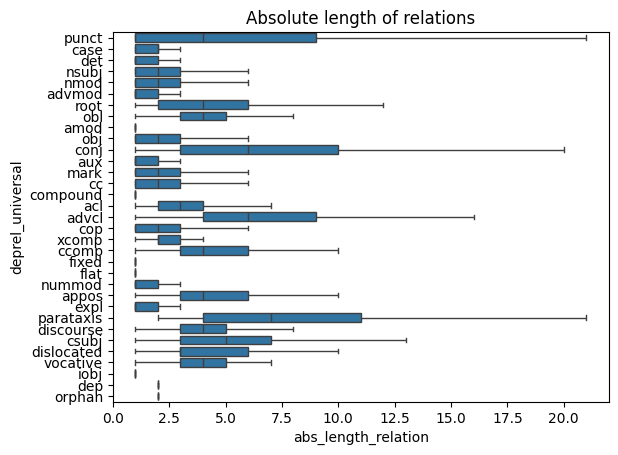

In [714]:
index_sort = df_ud.groupby("deprel_universal").transform("count").sort_values("sentence_id", ascending=False).index
ax = sns.boxplot(data=df_ud.loc[index_sort], y="deprel_universal", x="abs_length_relation", showfliers=False)
plt.title(f"Absolute length of relations")
plt.show()

In [715]:
df = df_ud.groupby("deprel_universal").agg({"abs_length_relation":"mean", "token_id":"count"}).sort_values("token_id", ascending=False).reset_index()
df = df.merge(pd.Series(D_RELATIONS, name="keep"), left_on="deprel_universal", right_index=True).sort_values("token_id", ascending=False)
fig = px.scatter(df.sort_values(by="keep", ascending=False), y="abs_length_relation", x="token_id", hover_data="deprel_universal",title="Mean absolute length of relations vs. number of tokens")
fig.show()
# fig.write_html("../images/universal-dependencies/UD_EWT_mean_length_relations_vs_count.html")

### Score attentional, sentence lengths

In [716]:
def calculate_attentionalScores(data, verbose=False):
    d = {"score_attentional":[], "length_attentional":[]}
    for i, sentence in enumerate(data):
        if i % 100 == 0 and verbose:
            print(f"Processing sentence {i}...")
        text = sentence.metadata["text"]
        burden = burdenizer.compute_burden(text)
        d["score_attentional"].append(burden)
        d["length_attentional"].append(len(burdenizer.tokens))
    return d

d_attentional = calculate_attentionalScores(data, verbose=True)
df_sentence = pd.DataFrame(d_attentional).reset_index().rename(columns={"index":"sentence_id"})
df_sentence = pd.merge(df_sentence, df_ud.groupby("sentence_id").agg({"token_id":"max"}).reset_index(),
            how="left", on="sentence_id").rename(columns={"token_id":"length_linguistics"})
df_sentence

Processing sentence 0...
Processing sentence 100...
Processing sentence 200...
Processing sentence 300...
Processing sentence 400...
Processing sentence 500...
Processing sentence 600...
Processing sentence 700...
Processing sentence 800...
Processing sentence 900...
Processing sentence 1000...
Processing sentence 1100...
Processing sentence 1200...
Processing sentence 1300...
Processing sentence 1400...
Processing sentence 1500...
Processing sentence 1600...
Processing sentence 1700...
Processing sentence 1800...
Processing sentence 1900...
Processing sentence 2000...
Processing sentence 2100...
Processing sentence 2200...
Processing sentence 2300...
Processing sentence 2400...
Processing sentence 2500...
Processing sentence 2600...
Processing sentence 2700...
Processing sentence 2800...
Processing sentence 2900...
Processing sentence 3000...
Processing sentence 3100...


,sentence_id,score_attentional,length_attentional,length_linguistics
0,0,0.472728,2,2
1,1,1.603659,6,5
2,2,4.102909,15,15
3,3,4.229439,16,14
4,4,2.794293,11,8
...,...,...,...,...
3171,3171,6.674907,25,15
3172,3172,7.829453,32,29
3173,3173,2.812665,10,8
3174,3174,1.862254,7,7


In [717]:
df = df_sentence[["length_linguistics", "length_attentional"]].melt().groupby(["variable", "value"], as_index=False).size().rename(columns={"size":"count",
                                                                                                                              "variable":"type",
                                                                                                                             "value":"length"})
fig = px.line(df, x="length", y="count", color="type")                                                                                                                        
fig.show()
# fig.write_html("../images/universal-dependencies/UD_EWT_length_linguistics_vs_attentional.html")

In [718]:
fig = px.line(df_sentence.groupby("length_attentional", as_index=False).agg({"score_attentional":"mean"}),
        x="length_attentional", y="score_attentional")
fig.show()
# fig.write_html("../images/universal-dependencies/UD_EWT_mean_attentional_score_vs_length.html")

### Correlation score attentional score linguistics

In [719]:
df_sentence = df_sentence.loc[(df_sentence["length_attentional"]<=50) & (df_sentence["length_attentional"]>=2)]
mask = np.minimum((df_sentence["length_attentional"]/df_sentence["length_linguistics"]).values,(df_sentence["length_linguistics"]/df_sentence["length_attentional"]).values)>0.75
df_sentence = df_sentence.loc[mask]
df_sentence

,sentence_id,score_attentional,length_attentional,length_linguistics
0,0,0.472728,2,2
1,1,1.603659,6,5
2,2,4.102909,15,15
3,3,4.229439,16,14
6,6,7.976808,31,26
...,...,...,...,...
3170,3170,1.465207,5,5
3172,3172,7.829453,32,29
3173,3173,2.812665,10,8
3174,3174,1.862254,7,7


In [720]:
l_df_spearman = []
for deprel in df_ud["deprel_universal"].unique():
    df = pd.merge(df_sentence
        ,df_ud.loc[(df_ud["sentence_id"].isin(df_sentence["sentence_id"]))&(df_ud["deprel_universal"]==deprel)].groupby("sentence_id").agg({"abs_length_relation":"mean"}).reset_index().rename(columns={"abs_length_relation":"score_linguistics"})
        ,how="inner", on="sentence_id")
    # df["score_linguistics_normalized"] = df["score_linguistics"]/df["length_linguistics"]
    l_spearmanr = []
    for length_attentional in np.sort(df["length_attentional"].unique()):
        a = df.loc[df["length_attentional"]==length_attentional, ["score_attentional", "score_linguistics"]].values
        a_attentional = a[:, 0]
        a_linguistics = a[:, 1]
        spearmanr = scipy.stats.spearmanr(a_attentional, a_linguistics)
        l_spearmanr.append((deprel, length_attentional, spearmanr.correlation, spearmanr.pvalue, len(a)))
    l_df_spearman.append(pd.DataFrame(l_spearmanr, columns=["deprel", "length_attentional", "correlation", "pvalue", "size"]))

/tmp/ipykernel_48539/2537113450.py:12: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/tmp/ipykernel_48539/2537113450.py:12: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/tmp/ipykernel_48539/2537113450.py:12: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/tmp/ipykernel_48539/2537113450.py:12: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/tmp/ipykernel_48539/2537113450.py:12: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/tmp/ipykernel_48539/2537113450.py:12: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/tmp/ipykernel_48539/2537113450.py:12: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/tmp/ipykernel_48539/2537113450.py:12: ConstantInputWar

In [721]:
df_spearman = pd.concat(l_df_spearman).dropna()
df_spearman["has_significant_pvalue"] = df_spearman["pvalue"]<0.05
df_spearman = df_spearman.loc[(df_spearman["has_significant_pvalue"])&(df_spearman["size"]>10)&(~df_spearman["deprel"].isin(["punct", "root"]))]
df_spearman.head(3)

,deprel,length_attentional,correlation,pvalue,size,has_significant_pvalue
7,obj,9,-0.311822,0.041794,43,True
23,obj,25,0.292425,0.048600,46,True
11,case,14,0.296062,0.009909,75,True


In [722]:
fig = px.scatter(df_spearman
        , x="length_attentional"
        , y="correlation"
        , color="deprel"
        , hover_data=["deprel", "pvalue", "size"])
fig.show()
# fig.write_html("../images/universal-dependencies/UD_EWT_spearman_correlation_linguistics_vs_attentional_by_length.html")

In [723]:
df_spearman.groupby("deprel").agg({"correlation":"mean", "size":"mean", "deprel":"count"}).rename(columns={"deprel":"count_deprel"}).sort_values("count_deprel", ascending=False)

,correlation,size,count_deprel
deprel,,,
nmod,0.404782,41.454545,11
nsubj,0.330671,91.909091,11
advcl,0.487340,26.333333,6
conj,0.432486,32.500000,4
advmod,0.070112,62.333333,3
amod,0.496535,27.333333,3
aux,0.517359,34.666667,3
cc,0.510250,29.666667,3
cop,0.438011,29.666667,3


### Combined relations

In [724]:
l_deprel_selected = ['nsubj', 'aux', 'advcl', 'conj']

In [725]:
# combined
df = pd.merge(df_sentence
    ,df_ud.loc[(df_ud["sentence_id"].isin(df_sentence["sentence_id"]))&(df_ud["deprel_universal"].isin(l_deprel_selected))].groupby("sentence_id").agg({"abs_length_relation":"mean"}).reset_index().rename(columns={"abs_length_relation":"score_linguistics"})
    ,how="inner", on="sentence_id")
l_spearmanr = []
for length_attentional in np.sort(df["length_attentional"].unique()):
    a = df.loc[df["length_attentional"]==length_attentional, ["score_attentional", "score_linguistics"]].values
    a_attentional = a[:, 0]
    a_linguistics = a[:, 1]
    spearmanr = scipy.stats.spearmanr(a_attentional, a_linguistics)
    l_spearmanr.append(("combined", length_attentional, spearmanr.correlation, spearmanr.pvalue, len(a)))
l_df_spearman.append(pd.DataFrame(l_spearmanr, columns=["deprel", "length_attentional", "correlation", "pvalue", "size"]))

/tmp/ipykernel_48539/4032504944.py:11: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



In [726]:
import plotly.graph_objects as go
df = pd.DataFrame(l_spearmanr, columns=["deprel", "length_attentional", "correlation", "pvalue", "size"])
df["significant_pvalue"] = df["pvalue"]<0.05
fig = px.line(df, x="length_attentional", y="correlation", markers=False
        ,hover_data=["pvalue", "size"])
fig.add_trace(go.Scatter(x=df["length_attentional"], y=df["correlation"], mode='markers', marker=dict(color=df["significant_pvalue"].map({True:"Green", False:"Red"})
                                                                                                      , size=df["size"]*0.1)))
fig.update_layout(title=f"Relation used: "+", ".join(l_deprel_selected) + " (red: p-value > 0.05, green: p-value < 0.05, size: number of samples)")
# fig.write_html("../images/universal-dependencies/UD_EWT_spearman_correlation_linguistics_vs_attentional_by_length_combined.html")
fig.show()

# <>

In [739]:
def parse_sentence_dependencies(data):
    l_head, l_deprel = [], []
    for sentence_id, sentence in enumerate(data):
        for token_id, token in enumerate(sentence):
            l_head.append((sentence_id, token_id+1, token["id"], token["form"], token["deprel"], token["head"]))
            deps = token["deps"]
            if isinstance(deps, list):
                for dep in deps:
                    l_deprel.append((sentence_id, token_id+1, token["id"], token["form"],)+dep)
    return l_head, l_deprel

def build_dfDeprel(l_deprel):
    df_deprel = pd.DataFrame(l_deprel, columns=["sentence_id", "token_id", "id", "form", "deprel", "head"])
    df_deprel = pd.merge(df_deprel, df_deprel[["sentence_id", "token_id", "id"]].rename(columns={"token_id":"token_head"}).drop_duplicates(),
    how="left", left_on=["sentence_id", "head"], right_on=["sentence_id", "id"], suffixes=("", "_head")).drop(columns=["id_head"])
    df_deprel["token_head"] = df_deprel.apply(lambda u: u["token_head"] if not(pd.isna(u["token_head"])) else u["head"], axis=1).astype(int)
    df_deprel["length_relation"] = df_deprel["token_head"] - df_deprel["token_id"]
    df_deprel["abs_length_relation"] = df_deprel["length_relation"].abs()
    df_deprel["deprel_universal"] = df_deprel["deprel"].apply(lambda u: u.split(":")[0])
    return df_deprel

def build_dfHead(l_head):
    df_head = pd.DataFrame(l_head, columns=["sentence_id", "token_id", "id", "form", "deprel", "head"]).dropna(subset=["head"])
    df_head["head"] = df_head["head"].astype(int)
    df_head["id"] = df_head["id"].astype(int)
    df_head = pd.merge(df_head, df_head[["sentence_id", "token_id", "id"]].rename(columns={"token_id":"token_head"}).drop_duplicates(),
    how="left", left_on=["sentence_id", "head"], right_on=["sentence_id", "id"], suffixes=("", "_head")).drop(columns=["id_head"])
    df_head["token_head"] = df_head.apply(lambda u: u["token_head"] if not(pd.isna(u["token_head"])) else u["head"], axis=1).astype(int)
    df_head["length_relation"] = df_head["head"] - df_head["id"]
    df_head["abs_length_relation"] = df_head["length_relation"].abs()
    df_head["deprel_universal"] = df_head["deprel"].apply(lambda u: u.split(":")[0])
    return df_head

def process_data(data):
    l_head, l_deprel = parse_sentence_dependencies(data)
    df_deprel = build_dfDeprel(l_deprel)
    df_head = build_dfHead(l_head)
    df_ud = df_deprel if len(df_deprel) > 0 else df_head
    df_ud["deprel_order"] = df_ud["deprel_universal"].map({k: i for i, k in enumerate(list(D_RELATIONS.keys()))})
    return df_ud

,sentence_id,token_id,id,form,deprel,head,token_head,length_relation,abs_length_relation,deprel_universal,deprel_order
0,0,1,1,what,root,0,0,-1,1,root,1
1,0,2,2,is,cop,1,1,-1,1,cop,15
2,0,3,3,the,det,4,4,1,1,det,4
3,0,4,4,cost,nsubj,1,1,-3,3,nsubj,2
4,0,5,5,of,case,7,7,2,2,case,3
...,...,...,...,...,...,...,...,...,...,...,...
48650,4273,4,4,flights,obj,1,1,-3,3,obj,8
48651,4273,5,5,from,case,6,6,1,1,case,3
48652,4273,6,6,cleveland,nmod,4,4,-2,2,nmod,6
48653,4273,7,7,to,case,8,8,1,1,case,3


In [745]:
datasets_ud_english = ["GUM", "EWT", "LinES", "ParTUT", "Atis"]

l_df = []
for dataset in datasets_ud_english:
    print(f"Processing {dataset}...")
    data_train = parse(open(f"/home/pierrick/datasets/Universal Dependencies 2.14/ud-treebanks-v2.14/UD_English-{dataset}/en_{dataset.lower()}-ud-train.conllu", "r").read())
    data_test = parse(open(f"/home/pierrick/datasets/Universal Dependencies 2.14/ud-treebanks-v2.14/UD_English-{dataset}/en_{dataset.lower()}-ud-test.conllu", "r").read())
    data_dev = parse(open(f"/home/pierrick/datasets/Universal Dependencies 2.14/ud-treebanks-v2.14/UD_English-{dataset}/en_{dataset.lower()}-ud-dev.conllu", "r").read())
    df_train = process_data(data_train)
    df_train["set"] = "train"
    df_test = process_data(data_test)
    df_test["set"] = "test"
    df_dev = process_data(data_dev)
    df_dev["set"] = "dev"
    df = pd.concat([df_train, df_test, df_dev])
    df["dataset"] = dataset
    l_df.append(df)

df_ud_english = pd.concat(l_df)
df_ud_english

Processing GUM...
Processing EWT...
Processing LinES...
Processing ParTUT...
Processing Atis...


,sentence_id,token_id,id,form,deprel,head,token_head,length_relation,abs_length_relation,deprel_universal,deprel_order,set,dataset
0,0,1,1,Aesthetic,amod,2,2,1,1,amod,9.0,train,GUM
1,0,2,2,Appreciation,root,0,0,-2,2,root,1.0,train,GUM
2,0,3,3,and,cc,5,5,2,2,cc,14.0,train,GUM
3,0,4,4,Spanish,amod,5,5,1,1,amod,9.0,train,GUM
4,0,5,5,Art,conj:and,2,2,-3,3,conj,12.0,train,GUM
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6639,571,7,7,land,root,0,0,-7,7,root,1.0,dev,Atis
6640,571,8,8,at,case,11,11,3,3,case,3.0,dev,Atis
6641,571,9,9,the,det,11,11,2,2,det,4.0,dev,Atis
6642,571,10,10,same,amod,11,11,1,1,amod,9.0,dev,Atis
